<a href="https://colab.research.google.com/github/IzaakGagnon/SSC_GliderProject/blob/main/Test_code/Persistent_Homology_Topological_Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ripser
!pip install persim
!pip install networkx
!pip install scikit-learn
!pip install matplotlib

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.4 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18102 sha256=7ef36f4bd450d6c345152137aab736a406a2f268a3651daf704dca6cf719f409
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial.distance import pdist, squareform
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

def split_large_component(component_indices, points, max_size):
    """
    Given a set of indices for a large connected component,
    split it into smaller clusters so that each resulting cluster has at most max_size points.
    """
    component_indices = np.array(list(component_indices))
    num_points = len(component_indices)
    n_clusters = int(np.ceil(num_points / max_size))
    component_points = points[component_indices]
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    sub_labels = kmeans.fit_predict(component_points)
    new_clusters = []
    for cl in np.unique(sub_labels):
        indices = component_indices[sub_labels == cl]
        new_clusters.append(set(indices))
    return new_clusters


In [75]:
# Load the dataset
sample_file = '/content/drive/MyDrive/Glider data/glider_data.h5'
df = pd.read_hdf(sample_file)
print("Initial dataset size:", df.shape[0])

from sklearn.preprocessing import StandardScaler

# For the sample, we use 5000 rows
df_sample = df.sample(n=2000, random_state=42)
df_sample = df_sample.dropna()
df_sample = df_sample.drop(columns=['time'], errors='ignore')

# Remove the oxygen column because it is our dependent variable.
if 'oxygen' in df_sample.columns:
    df_sample = df_sample.drop(columns=['oxygen'])

# Select only the features for topology: latitude, longitude, and depth.
# (Adjust the order if desired; here we assume columns are named exactly.)
required_features = ['latitude', 'longitude', 'depth', 'salinity', 'density', 'temperature']
if not all(col in df_sample.columns for col in required_features):
    raise ValueError(f"One or more required columns {required_features} not found in the sample data.")

df_features = df_sample[required_features]
scaler = StandardScaler()
points = scaler.fit_transform(df_features.values)
n_points = points.shape[0]
print("Number of sample points used for homology:", n_points)


Initial dataset size: 10356849
Number of sample points used for homology: 2000


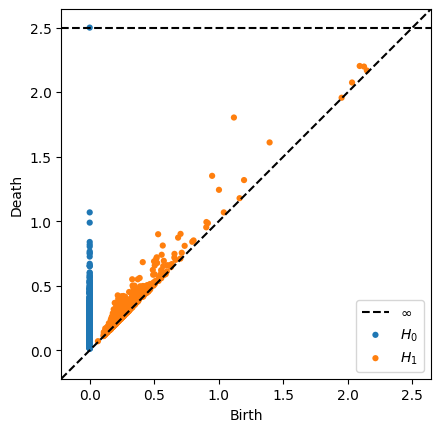

In [76]:
result = ripser(points, maxdim=1)
diagrams = result['dgms']
plot_diagrams(diagrams, show=True)


In [77]:
threshold_input = input("The persistence diagram is displayed.\nEnter connectivity threshold (e.g., 15): ")
try:
    threshold = float(threshold_input)
except ValueError:
    print("Invalid input. Using default threshold of 15")
    threshold = 15.0
print("Chosen connectivity threshold (epsilon):", threshold)


The persistence diagram is displayed.
Enter connectivity threshold (e.g., 15): 1
Chosen connectivity threshold (epsilon): 1.0


In [78]:
dist_matrix = squareform(pdist(points))
G = nx.Graph()
G.add_nodes_from(range(n_points))
for i in range(n_points):
    for j in range(i + 1, n_points):
        if dist_matrix[i, j] <= threshold:
            G.add_edge(i, j)

components = list(nx.connected_components(G))
print("Number of connected components before splitting:", len(components))


Number of connected components before splitting: 2


In [84]:
max_size = len(df_sample) / 15  # Adjust this factor as needed.
new_components = []
for comp in components:
    if len(comp) > max_size:
        split_comps = split_large_component(comp, points, max_size)
        new_components.extend(split_comps)
    else:
        new_components.append(comp)
print("Number of components after splitting:", len(new_components))


Number of components after splitting: 16


In [85]:
labels = np.empty(n_points, dtype=int)
for label, comp in enumerate(new_components):
    for idx in comp:
        labels[idx] = label


In [86]:
# Merge clusters that are very small relative to the median cluster size.
cluster_sizes = np.array([len(comp) for comp in new_components])
median_size = np.median(cluster_sizes)
min_size_threshold = 0.5 * median_size  # Merge clusters smaller than 50% of median size.
print("Median cluster size:", median_size)
print("Merging clusters smaller than:", min_size_threshold)

num_clusters = len(new_components)
# Compute centroids for each cluster (using the sample points)
centroids = np.zeros((num_clusters, points.shape[1]))
for i, comp in enumerate(new_components):
    comp_indices = list(comp)
    centroids[i] = np.mean(points[comp_indices], axis=0)

# For each cluster that is too small, merge it into the nearest cluster (by centroid distance)
for i in range(num_clusters):
    if cluster_sizes[i] < min_size_threshold:
        distances = np.linalg.norm(centroids[i] - centroids, axis=1)
        distances[i] = np.inf  # ignore self-distance
        nearest = np.argmin(distances)
        print(f"Merging small cluster {i} (size {cluster_sizes[i]}) into cluster {nearest} (size {cluster_sizes[nearest]})")
        labels[labels == i] = nearest


Median cluster size: 117.5
Merging clusters smaller than: 58.75
Merging small cluster 14 (size 30) into cluster 6 (size 102)
Merging small cluster 15 (size 1) into cluster 6 (size 102)


In [87]:
# Load and preprocess the full dataset.
df_full = pd.read_hdf(sample_file)
print("Full dataset shape before cleaning:", df_full.shape)
df_full = df_full.dropna()
df_full = df_full.drop(columns=['time'], errors='ignore')
print("Full dataset shape after cleaning:", df_full.shape)

# For cluster assignment, use only latitude, longitude, and depth features.
if not all(col in df_full.columns for col in required_features):
    raise ValueError(f"One or more required columns {required_features} not found in the full dataset.")

df_full_features = df_full[required_features]
full_points = scaler.transform(df_full_features.values)

# Build a nearest neighbor model using the sample points (with topology clusters)
nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(points)
distances, indices = nbrs.kneighbors(full_points)
distances = distances.flatten()
indices = indices.flatten()

# For each full dataset point, if its nearest sample point is within the threshold,
# assign the corresponding (merged) cluster label; otherwise, mark as noise (-1).
full_labels = np.where(distances <= threshold, labels[indices], -1)
df_full['component_label'] = full_labels

print("Full dataset cluster assignment complete.")
print("Cluster label counts:", dict(zip(*np.unique(full_labels, return_counts=True))))


Full dataset shape before cleaning: (10356849, 8)
Full dataset shape after cleaning: (10356849, 7)
Full dataset cluster assignment complete.
Cluster label counts: {np.int64(-1): np.int64(9278), np.int64(0): np.int64(1576846), np.int64(1): np.int64(696998), np.int64(2): np.int64(579514), np.int64(3): np.int64(763117), np.int64(4): np.int64(558131), np.int64(5): np.int64(618780), np.int64(6): np.int64(706458), np.int64(7): np.int64(552197), np.int64(8): np.int64(784671), np.int64(9): np.int64(617378), np.int64(10): np.int64(957532), np.int64(11): np.int64(760292), np.int64(12): np.int64(509059), np.int64(13): np.int64(666598)}


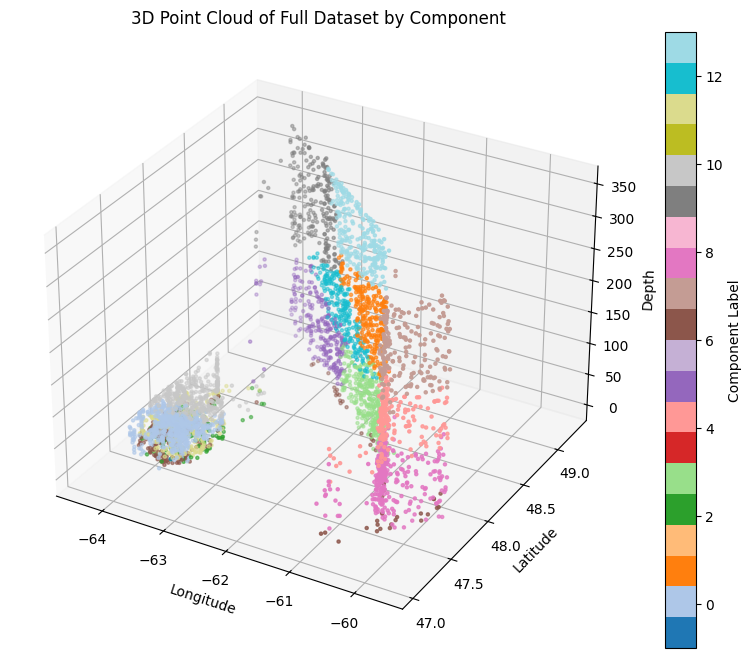

In [88]:
# Here we use latitude, longitude, and depth for a 3D plot.
df_full_sample = df_full.sample(n=4000, random_state=42)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df_full_sample['longitude'], df_full_sample['latitude'], df_full_sample['depth'],
                c=df_full_sample['component_label'], cmap='tab20', s=5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth')
plt.title("3D Point Cloud of Full Dataset by Component")
plt.colorbar(sc, label='Component Label')
plt.show()


In [45]:
unique_clusters = np.unique(full_labels)
for cluster in unique_clusters:
    subset = df_full[df_full['component_label'] == cluster]
    filename = f"component_{cluster}.h5"
    subset.to_hdf(filename, key='df', mode='w')
    print(f"Saved cluster {cluster} with {len(subset)} points to {filename}")


Saved cluster 0 with 643499 points to component_0.h5
Saved cluster 1 with 1163695 points to component_1.h5
Saved cluster 2 with 554874 points to component_2.h5
Saved cluster 4 with 1081560 points to component_4.h5
Saved cluster 5 with 1041070 points to component_5.h5
Saved cluster 6 with 891049 points to component_6.h5
Saved cluster 7 with 674209 points to component_7.h5
Saved cluster 8 with 1178773 points to component_8.h5
Saved cluster 9 with 820164 points to component_9.h5
Saved cluster 10 with 767163 points to component_10.h5
Saved cluster 11 with 840733 points to component_11.h5
Saved cluster 12 with 700060 points to component_12.h5
